In [25]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.types import StringType, BooleanType, IntegerType, DoubleType, NumericType
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array
import numpy as np

# Data Understanding Section

## Loading the dataset and spark setup

In [12]:
spark = SparkSession.builder.appName("myapp").master('local[*]').getOrCreate()

In [13]:
df = spark.read.csv('dataset/Base.csv', header=True, inferSchema=True)

Here i'm checking how many cores are being used by spark

In [4]:
num_cores = spark.sparkContext.defaultParallelism
print(f"Spark is using {num_cores} cores.")

Spark is using 12 cores.


## Exploring the dataset

In [14]:
df.show()

24/11/12 15:45:04 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+------------------+---------------------+-------------------------+----------------------------+------------+------------------+----------------------+------------+------------+------------------+------------------+------------------+--------------------+--------------------------------+-----------------+-----------------+-------------+--------------+----------------+------------------+-----------------+---------------+---------------------+---------------+--------+-------------------------+---------+------------------+-------------------------+------------------+-----+
|fraud_bool|            income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|days_since_request|intended_balcon_amount|payment_type|zip_count_4w|       velocity_6h|      velocity_24h|       velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|employment_status|credit_risk_score|email_is_free|housing_status|phone_home_valid|phone_mobile_valid|bank_month

In [23]:
# Print the schema of the DataFrame
df.printSchema()

root
 |-- fraud_bool: integer (nullable = true)
 |-- income: double (nullable = true)
 |-- name_email_similarity: double (nullable = true)
 |-- prev_address_months_count: integer (nullable = true)
 |-- current_address_months_count: integer (nullable = true)
 |-- customer_age: integer (nullable = true)
 |-- days_since_request: double (nullable = true)
 |-- intended_balcon_amount: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- zip_count_4w: integer (nullable = true)
 |-- velocity_6h: double (nullable = true)
 |-- velocity_24h: double (nullable = true)
 |-- velocity_4w: double (nullable = true)
 |-- bank_branch_count_8w: integer (nullable = true)
 |-- date_of_birth_distinct_emails_4w: integer (nullable = true)
 |-- employment_status: string (nullable = true)
 |-- credit_risk_score: integer (nullable = true)
 |-- email_is_free: integer (nullable = true)
 |-- housing_status: string (nullable = true)
 |-- phone_home_valid: integer (nullable = true)
 |-- phone_mobil

## Get the number of unique values in each column of the DataFrame

In [24]:
for col_name in df.columns:
    print(f"The column '{col_name}' has {df.select(col_name).distinct().count()} unique values.")

The column 'fraud_bool' has 2 unique values.


The column 'income' has 9 unique values.


The column 'name_email_similarity' has 998861 unique values.


The column 'prev_address_months_count' has 374 unique values.


The column 'current_address_months_count' has 423 unique values.


The column 'customer_age' has 9 unique values.


The column 'days_since_request' has 989330 unique values.


The column 'intended_balcon_amount' has 994971 unique values.


The column 'payment_type' has 5 unique values.


The column 'zip_count_4w' has 6306 unique values.


The column 'velocity_6h' has 998687 unique values.


The column 'velocity_24h' has 998940 unique values.


The column 'velocity_4w' has 998318 unique values.


The column 'bank_branch_count_8w' has 2326 unique values.


The column 'date_of_birth_distinct_emails_4w' has 40 unique values.


The column 'employment_status' has 7 unique values.


The column 'credit_risk_score' has 551 unique values.


The column 'email_is_free' has 2 unique values.


The column 'housing_status' has 7 unique values.


The column 'phone_home_valid' has 2 unique values.


The column 'phone_mobile_valid' has 2 unique values.


The column 'bank_months_count' has 33 unique values.


The column 'has_other_cards' has 2 unique values.


The column 'proposed_credit_limit' has 12 unique values.


The column 'foreign_request' has 2 unique values.


The column 'source' has 2 unique values.


The column 'session_length_in_minutes' has 994887 unique values.


The column 'device_os' has 5 unique values.


The column 'keep_alive_session' has 2 unique values.


The column 'device_distinct_emails_8w' has 4 unique values.


The column 'device_fraud_count' has 1 unique values.


The column 'month' has 8 unique values.


In [25]:
df.describe()

DataFrame[summary: string, fraud_bool: string, income: string, name_email_similarity: string, prev_address_months_count: string, current_address_months_count: string, customer_age: string, days_since_request: string, intended_balcon_amount: string, payment_type: string, zip_count_4w: string, velocity_6h: string, velocity_24h: string, velocity_4w: string, bank_branch_count_8w: string, date_of_birth_distinct_emails_4w: string, employment_status: string, credit_risk_score: string, email_is_free: string, housing_status: string, phone_home_valid: string, phone_mobile_valid: string, bank_months_count: string, has_other_cards: string, proposed_credit_limit: string, foreign_request: string, source: string, session_length_in_minutes: string, device_os: string, keep_alive_session: string, device_distinct_emails_8w: string, device_fraud_count: string, month: string]

## Looking for missing values

In [47]:
#Check if there are any missing values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----------+------+---------------------+-------------------------+----------------------------+------------+------------------+----------------------+------------+------------+-----------+------------+-----------+--------------------+--------------------------------+-----------------+-----------------+-------------+--------------+----------------+------------------+-----------------+---------------+---------------------+---------------+------+-------------------------+---------+------------------+-------------------------+------------------+-----+
|fraud_bool|income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|days_since_request|intended_balcon_amount|payment_type|zip_count_4w|velocity_6h|velocity_24h|velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|employment_status|credit_risk_score|email_is_free|housing_status|phone_home_valid|phone_mobile_valid|bank_months_count|has_other_cards|proposed_credit_limit|foreign_request|sour

There are no missing values in the dataset

## Checking the data types and values of the columns

In [49]:
#Check for outliers
df.describe().show()

+-------+-------------------+-------------------+---------------------+-------------------------+----------------------------+------------------+--------------------+----------------------+------------+------------------+-------------------+------------------+-----------------+--------------------+--------------------------------+-----------------+-----------------+------------------+--------------+-------------------+-------------------+------------------+-----------------+---------------------+-------------------+--------+-------------------------+---------+-------------------+-------------------------+------------------+------------------+
|summary|         fraud_bool|             income|name_email_similarity|prev_address_months_count|current_address_months_count|      customer_age|  days_since_request|intended_balcon_amount|payment_type|      zip_count_4w|        velocity_6h|      velocity_24h|      velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|employment_status

## Looking at the distribution of the target variable 'fraud_bool'

In [6]:
#Distribution of the target variable 'fraud_bool'
df.groupBy('fraud_bool').count().show()

#Print the distribution in percentage
df.groupBy('fraud_bool').count().withColumn('percentage', col('count') / df.count() * 100).show()

+----------+------+
|fraud_bool| count|
+----------+------+
|         1| 11029|
|         0|988971|
+----------+------+


+----------+------+-----------------+
|fraud_bool| count|       percentage|
+----------+------+-----------------+
|         1| 11029|           1.1029|
|         0|988971|98.89710000000001|
+----------+------+-----------------+


[Text(0, 0, 'Non Fraudulent'), Text(1, 0, 'Fraudulent')]

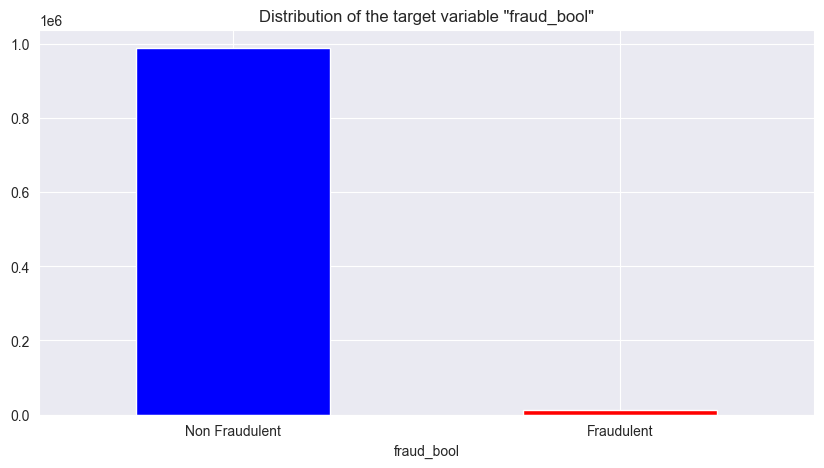

In [10]:
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()

# Plot the distribution of the 'fraud_bool' column
plot = pandas_df['fraud_bool'].value_counts().plot(kind='bar', figsize=(10, 5), title='Distribution of the target variable "fraud_bool"', color=['blue', 'red'])
plot.set_xticklabels(['Non Fraudulent', 'Fraudulent'], rotation=0)

The dataset is, as expected, highly imbalanced towards the non-fraudulent transactions. This is a common issue in fraud detection problems, and we will need to address it later on.

## Looking at the distribution of the Income Value

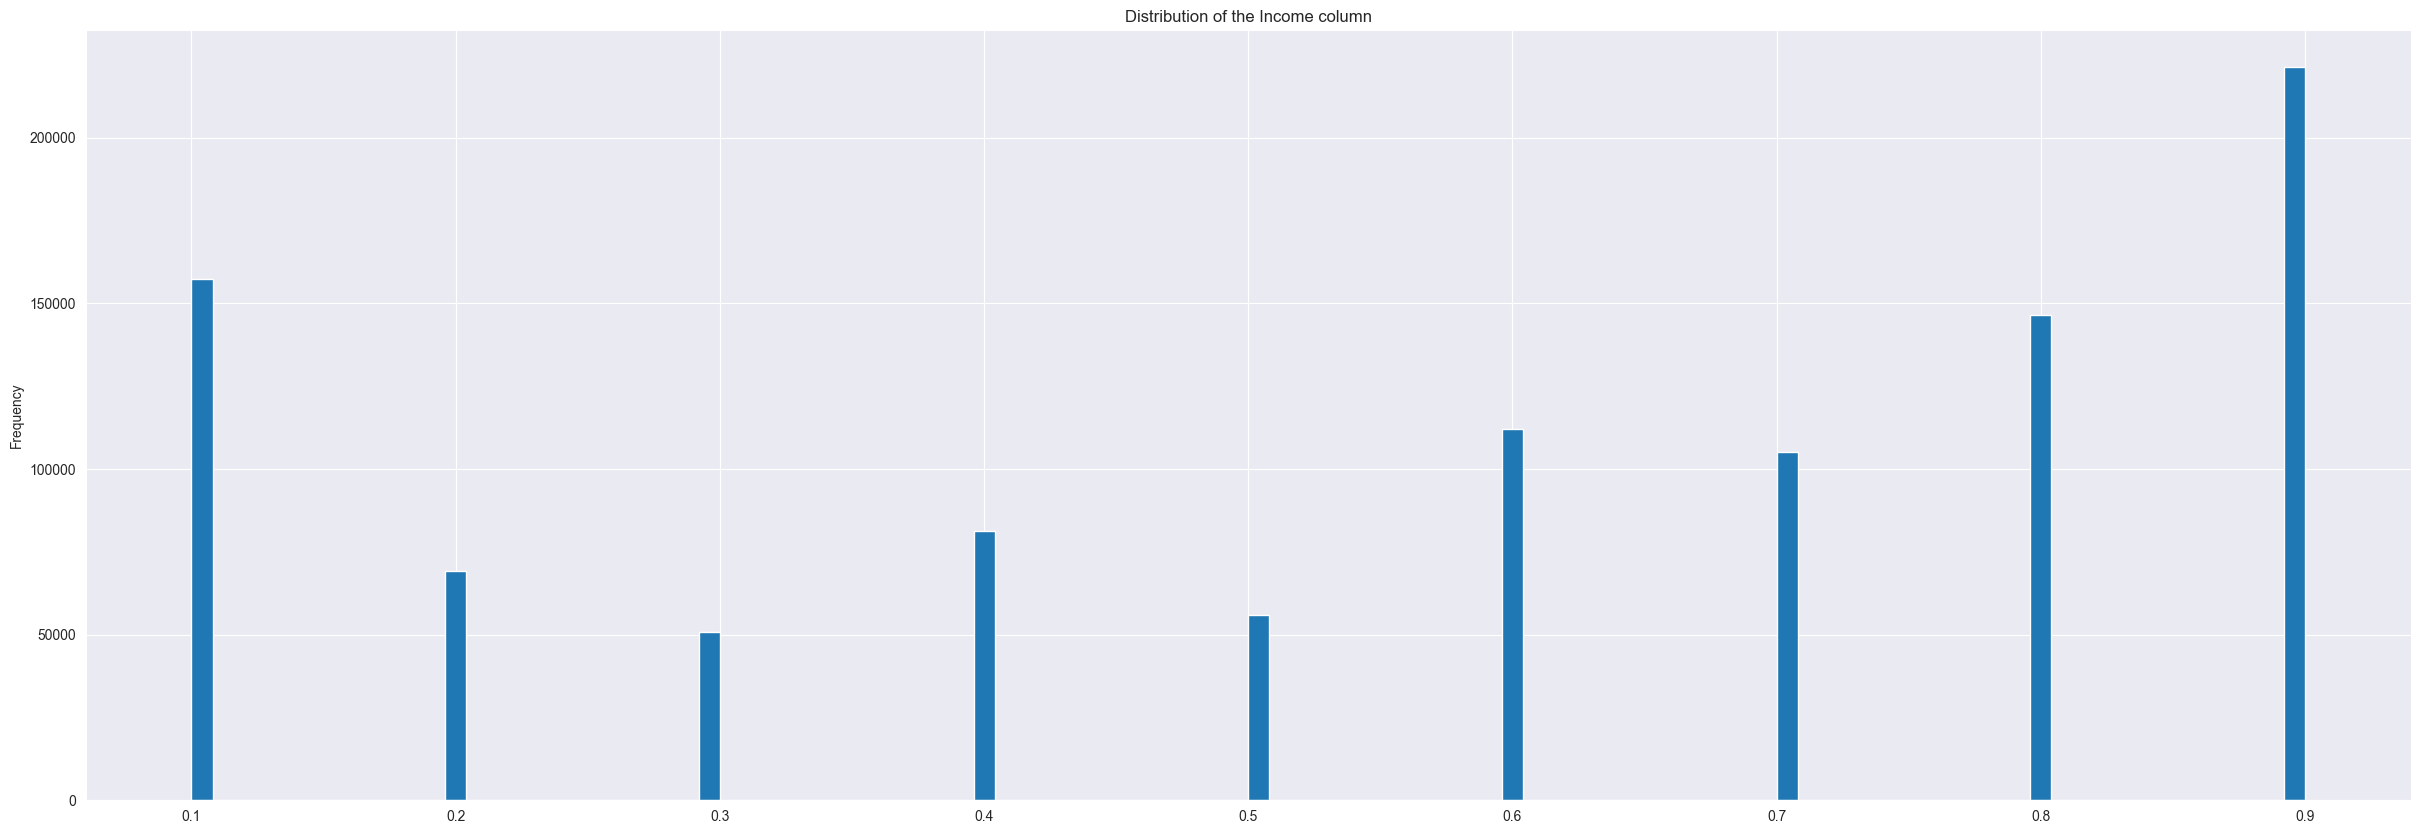

In [5]:
# Plotting the distribution of the 'Income' column

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()

# Plot the distribution of the 'Income' column
pandas_df['income'].plot(kind='hist', bins=100, figsize=(30, 10), title='Distribution of the Income column')
plt.show()

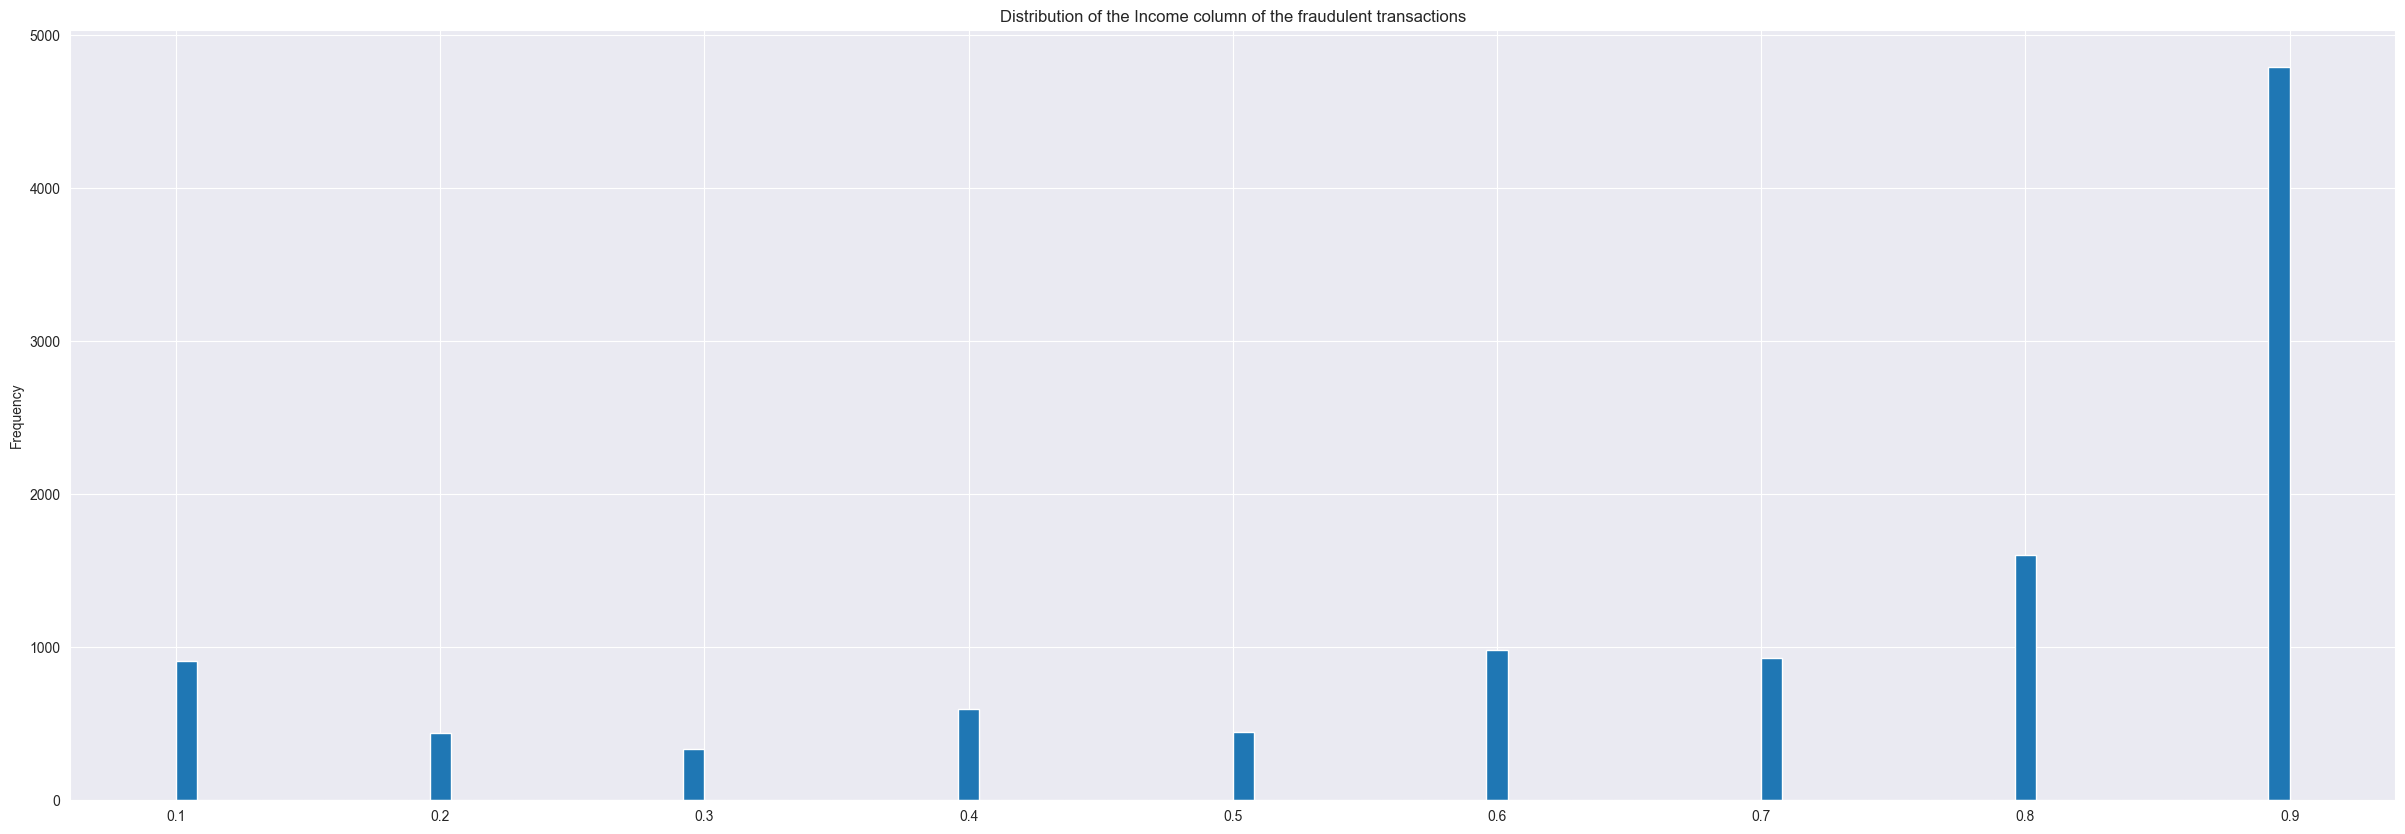

In [11]:
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()

# Plot the distribution of the 'Income' column of the fraudulent transactions
pandas_df[pandas_df['fraud_bool'] == 1]['income'].plot(kind='hist', bins=100, figsize=(30, 10), title='Distribution of the Income column of the fraudulent transactions')
plt.show()

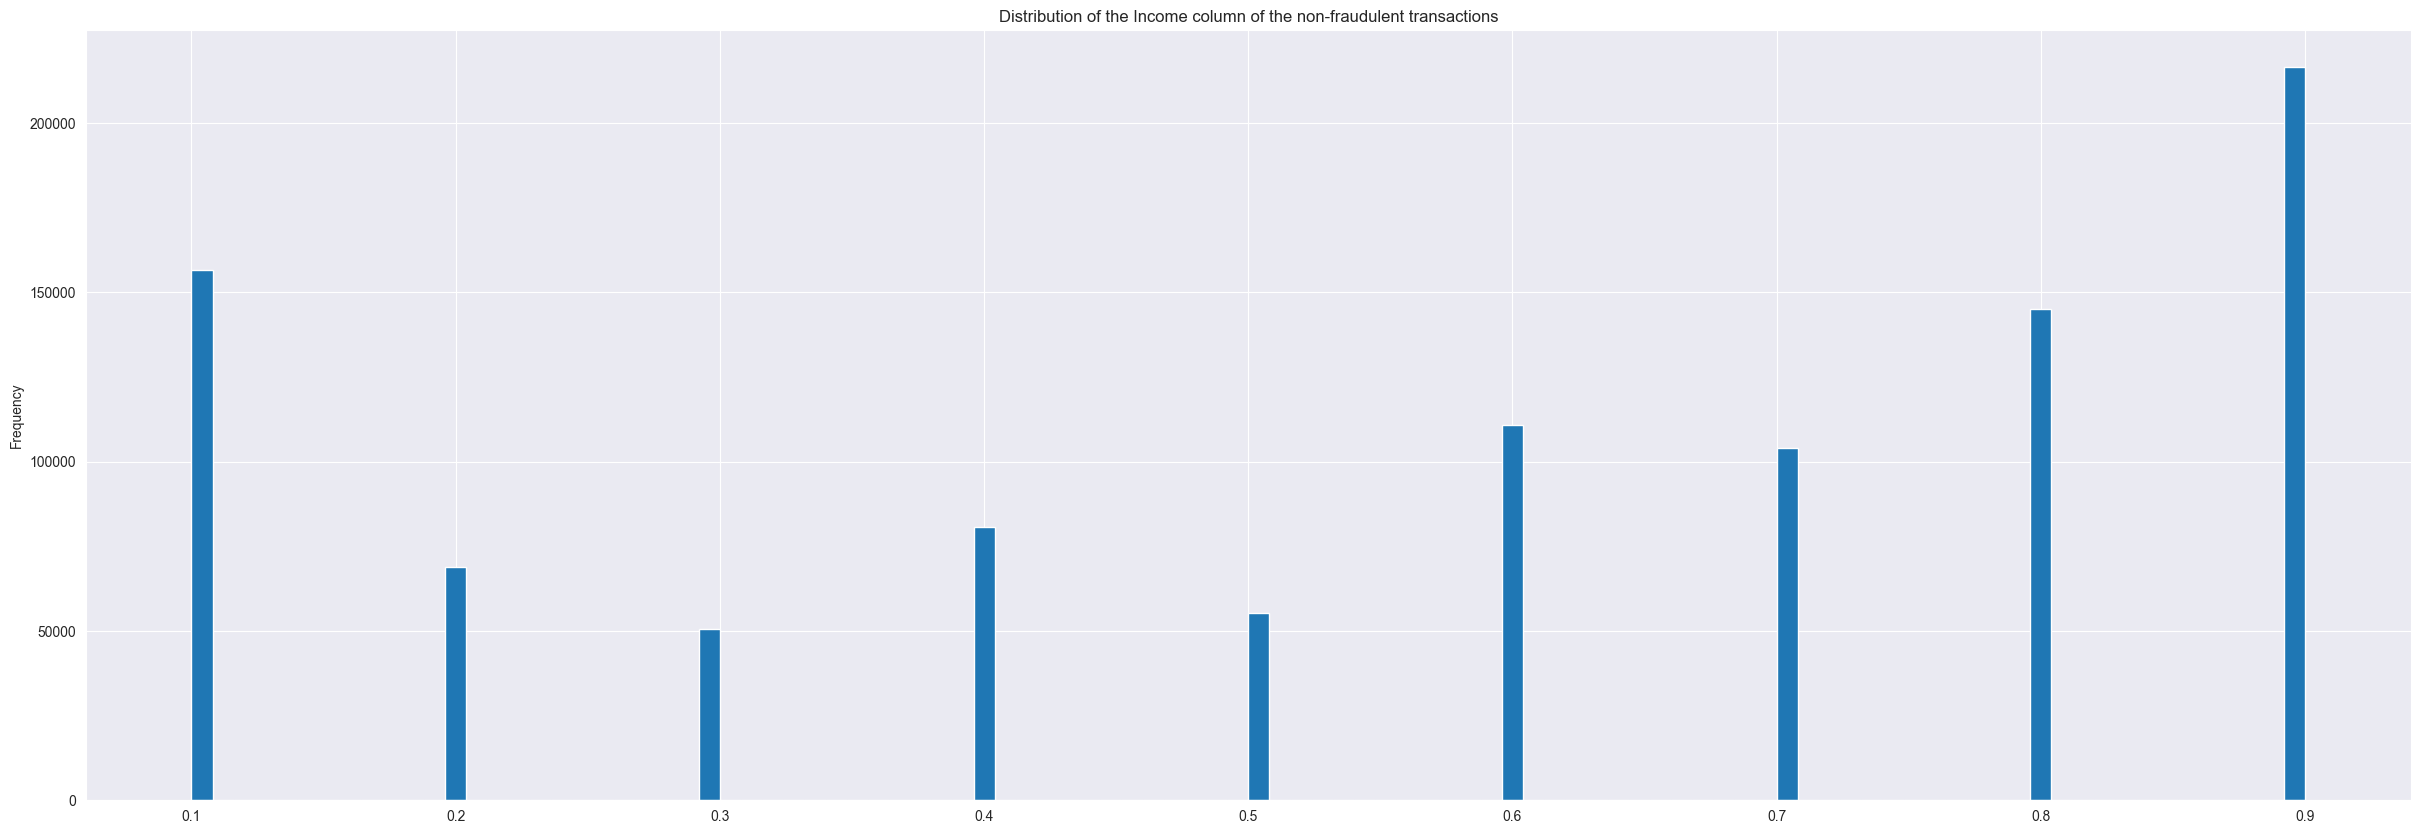

In [12]:
pandas_df[pandas_df['fraud_bool'] == 0]['income'].plot(kind='hist', bins=100, figsize=(30, 10),
                                                       title='Distribution of the Income column of the non-fraudulent transactions')
plt.show()

We can notice that the fraudulent transactions applicants have a higher income value compared to the non-fraudulent transactions. 

## Looking at the distribution of the Age Value

In [14]:
df.groupBy('customer_age').count().show()

+------------+------+
|customer_age| count|
+------------+------+
|          40|238712|
|          20|245855|
|          10| 20987|
|          50|140353|
|          80|  1297|
|          70|  6517|
|          60| 34770|
|          90|    76|
|          30|311433|
+------------+------+


We can see that the age values are not continuous, but discrete. This is because the age values are binned into ranges. Also the majority of the customers are in the age range of 20-40.

In [15]:
non_fraudulent_age = df.filter(df['fraud_bool'] == 0).groupBy('customer_age').count()
non_fraudulent_age = non_fraudulent_age.withColumn('percentage', (col('count') / df.filter(df['fraud_bool'] == 0).count()) * 100)
non_fraudulent_age = non_fraudulent_age.orderBy('percentage', ascending=False)
print("Non-Fraudulent Transactions by Customer Age:")
non_fraudulent_age.show()

Non-Fraudulent Transactions by Customer Age:


+------------+------+--------------------+
|customer_age| count|          percentage|
+------------+------+--------------------+
|          30|308844|  31.228822685397244|
|          20|244650|  24.737833566403868|
|          40|235836|  23.846604197696394|
|          50|137548|  13.908193465733575|
|          60| 33621|  3.3995941235890634|
|          10| 20913|   2.114622167889655|
|          70|  6254|  0.6323744578961366|
|          80|  1233| 0.12467504102749222|
|          90|    72|0.007280294366568889|
+------------+------+--------------------+


In [16]:
# Filter for fraudulent transactions, group by customer_age, count occurrences, and calculate percentage
fraudulent_age = df.filter(df['fraud_bool'] == 1).groupBy('customer_age').count()
fraudulent_age = fraudulent_age.withColumn('percentage', (col('count') / df.filter(df['fraud_bool'] == 1).count()) * 100)
fraudulent_age = fraudulent_age.orderBy('percentage', ascending=False)
print("Fraudulent Transactions by Customer Age:")
fraudulent_age.show()

Fraudulent Transactions by Customer Age:


+------------+-----+-------------------+
|customer_age|count|         percentage|
+------------+-----+-------------------+
|          40| 2876| 26.076706863722915|
|          50| 2805| 25.432949496781216|
|          30| 2589| 23.474476380451538|
|          20| 1205|   10.9257412276725|
|          60| 1149| 10.417988938253695|
|          70|  263|  2.384622359234745|
|          10|   74|  0.670958382446278|
|          80|   64| 0.5802883307643485|
|          90|    4|0.03626802067277178|
+------------+-----+-------------------+


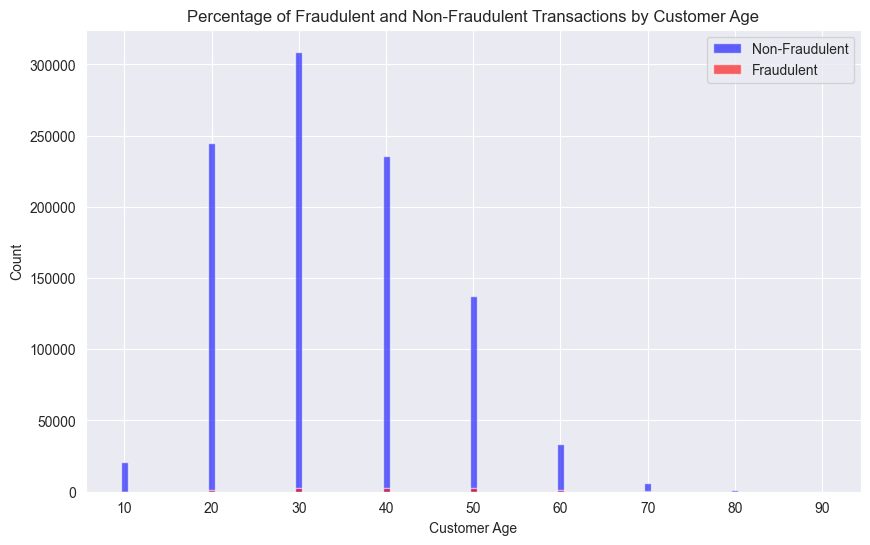

In [30]:
plt.figure(figsize=(10, 6))
plt.bar(non_fraudulent_age['customer_age'], non_fraudulent_age['count'], color='blue', alpha=0.6, label='Non-Fraudulent')
plt.bar(fraudulent_age['customer_age'], fraudulent_age['count'], color='red', alpha=0.6, label='Fraudulent')
plt.xlabel('Customer Age')
plt.ylabel('Count')
plt.title('Percentage of Fraudulent and Non-Fraudulent Transactions by Customer Age')
plt.legend()

plt.show()

From these data i think that we can say that there is a slight shift in fraudulent transactions towards the brackets 40 and 50 compared to non-fraudulent ones. The lower percentage of fraudulent transactions among young people like those in the 20 bracket could indicate more attention by the customers or maybe that having in general less money they tend to be less targeted by fraudsters. 

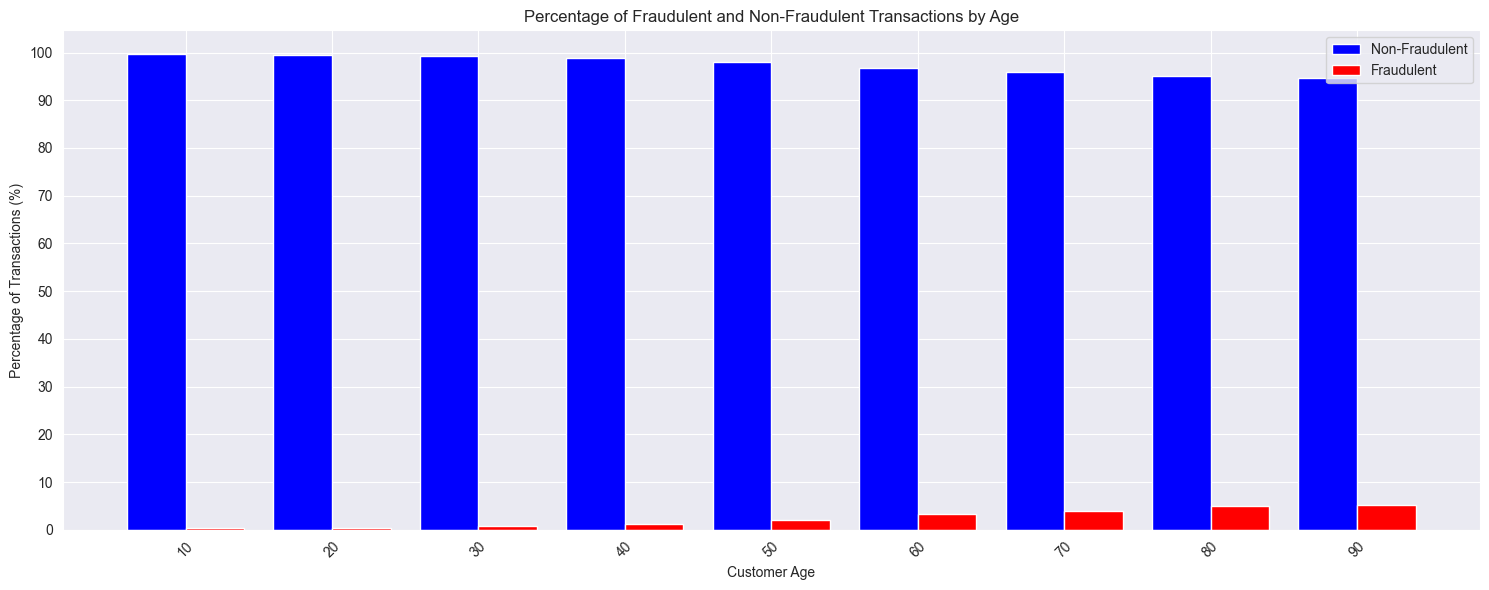

In [34]:
from pyspark.sql import functions as F

# Group by customer_age and calculate total transactions and fraud transactions
age_group = df.groupBy("customer_age").agg(
    F.count("*").alias("total_transactions"),
    F.sum("fraud_bool").alias("fraud_transactions")
)

# Calculate fraud and non-fraud percentages
age_group = age_group.withColumn(
    "fraud_percentage",
    (F.col("fraud_transactions") / F.col("total_transactions")) * 100
).withColumn(
    "non_fraud_percentage",
    100 - F.col("fraud_percentage")
)

# Convert to Pandas for plotting
age_group_pd = age_group.orderBy("customer_age").toPandas()

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

# Plot side-by-side bars
bar_width = 0.4
ages = age_group_pd['customer_age']
x = range(len(ages))

plt.bar([i - bar_width/2 for i in x], age_group_pd['non_fraud_percentage'],
        width=bar_width, color='blue', label='Non-Fraudulent')

plt.bar([i + bar_width/2 for i in x], age_group_pd['fraud_percentage'],
        width=bar_width, color='red', label='Fraudulent')

# Add labels and title
plt.xlabel('Customer Age')
plt.ylabel('Percentage of Transactions (%)')
plt.title('Percentage of Fraudulent and Non-Fraudulent Transactions by Age')
plt.xticks(x, ages, rotation=45)
plt.yticks(range(0, 101, 10))
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

## Checking the number of missing values among the columns that by dataset description contains them with the value '-1'

In [5]:
import pandas as pd

# List of features to check for missing values
missing_features = ['prev_address_months_count', 'current_address_months_count', 'intended_balcon_amount', 'bank_months_count', 'session_length_in_minutes', 'device_distinct_emails_8w']

# Initialize an empty DataFrame to hold the percentage of missing values for each feature
missing_vals = pd.DataFrame()

# For each feature, replace -1 values with NaN, calculate the percentage of missing values, and add to the missing_vals DataFrame
for feature in missing_features:
    df = df.withColumn(feature, when(col(feature) < 0, None).otherwise(col(feature)))  # Replace -1 values with NaN
    missing_vals_col = df.groupBy('fraud_bool').agg(
        (count(when(col(feature).isNull(), feature)) / count('*') * 100).alias(feature)
    ).toPandas().set_index('fraud_bool')[feature]
    missing_vals[feature] = missing_vals_col

print(missing_vals)

            prev_address_months_count  current_address_months_count  \
fraud_bool                                                            
1                           91.885030                      0.126938   
0                           71.062347                      0.428728   

            intended_balcon_amount  bank_months_count  \
fraud_bool                                              
1                        88.376099          37.537401   
0                        74.094791          25.227737   

            session_length_in_minutes  device_distinct_emails_8w  
fraud_bool                                                        
1                            0.163206                   0.036268  
0                            0.201927                   0.035896  


In [6]:
# Reshape the missing_vals DataFrame from wide to long format
missing_vals = pd.DataFrame(missing_vals.T.stack())

# Reset the index and rename the columns
missing_vals.reset_index(inplace=True)
missing_vals.rename(columns={'level_0': 'feature', 0: 'missing_vals'}, inplace=True)

print(missing_vals)

                         feature  fraud_bool  missing_vals
0      prev_address_months_count           1     91.885030
1      prev_address_months_count           0     71.062347
2   current_address_months_count           1      0.126938
3   current_address_months_count           0      0.428728
4         intended_balcon_amount           1     88.376099
5         intended_balcon_amount           0     74.094791
6              bank_months_count           1     37.537401
7              bank_months_count           0     25.227737
8      session_length_in_minutes           1      0.163206
9      session_length_in_minutes           0      0.201927
10     device_distinct_emails_8w           1      0.036268
11     device_distinct_emails_8w           0      0.035896


<Figure size 800x600 with 0 Axes>

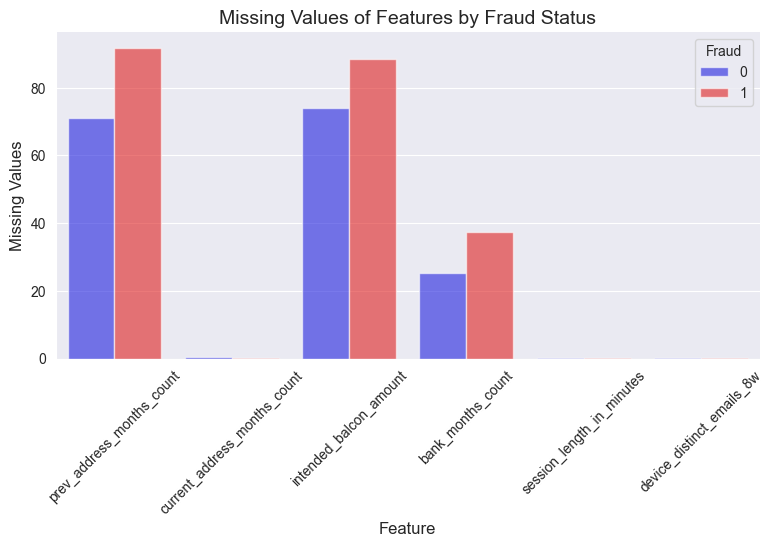

In [12]:
import seaborn as sns

# Set up plot
plt.figure(figsize=(8, 6))

# Create bar plot
sns.catplot(data=missing_vals, kind="bar", x="feature", y="missing_vals", hue="fraud_bool", alpha=.6, height=4, aspect=2, legend=True, legend_out=False, palette=['blue', 'red'])

# Customize labels and legend
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Missing Values", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.title("Missing Values of Features by Fraud Status", fontsize=14)
plt.legend(title="Fraud", fontsize=10)

# Display plot
plt.show()

When examining features like prev_address_months_count, intended_balcon_amount, and bank_months_count, it becomes apparent that a considerable number of missing values exist in their original distribution. However, despite these missing values, these features still hold informative value and exhibit correlation with the target feature.

## Checking distribution of numeric features

In [9]:
numeric_features = [col for col in df.columns
                    if isinstance(df.schema[col].dataType, NumericType) and df.select(col).distinct().count() >= 10]


print(numeric_features)

['name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'bank_months_count', 'proposed_credit_limit', 'session_length_in_minutes']


24/11/10 15:00:05 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


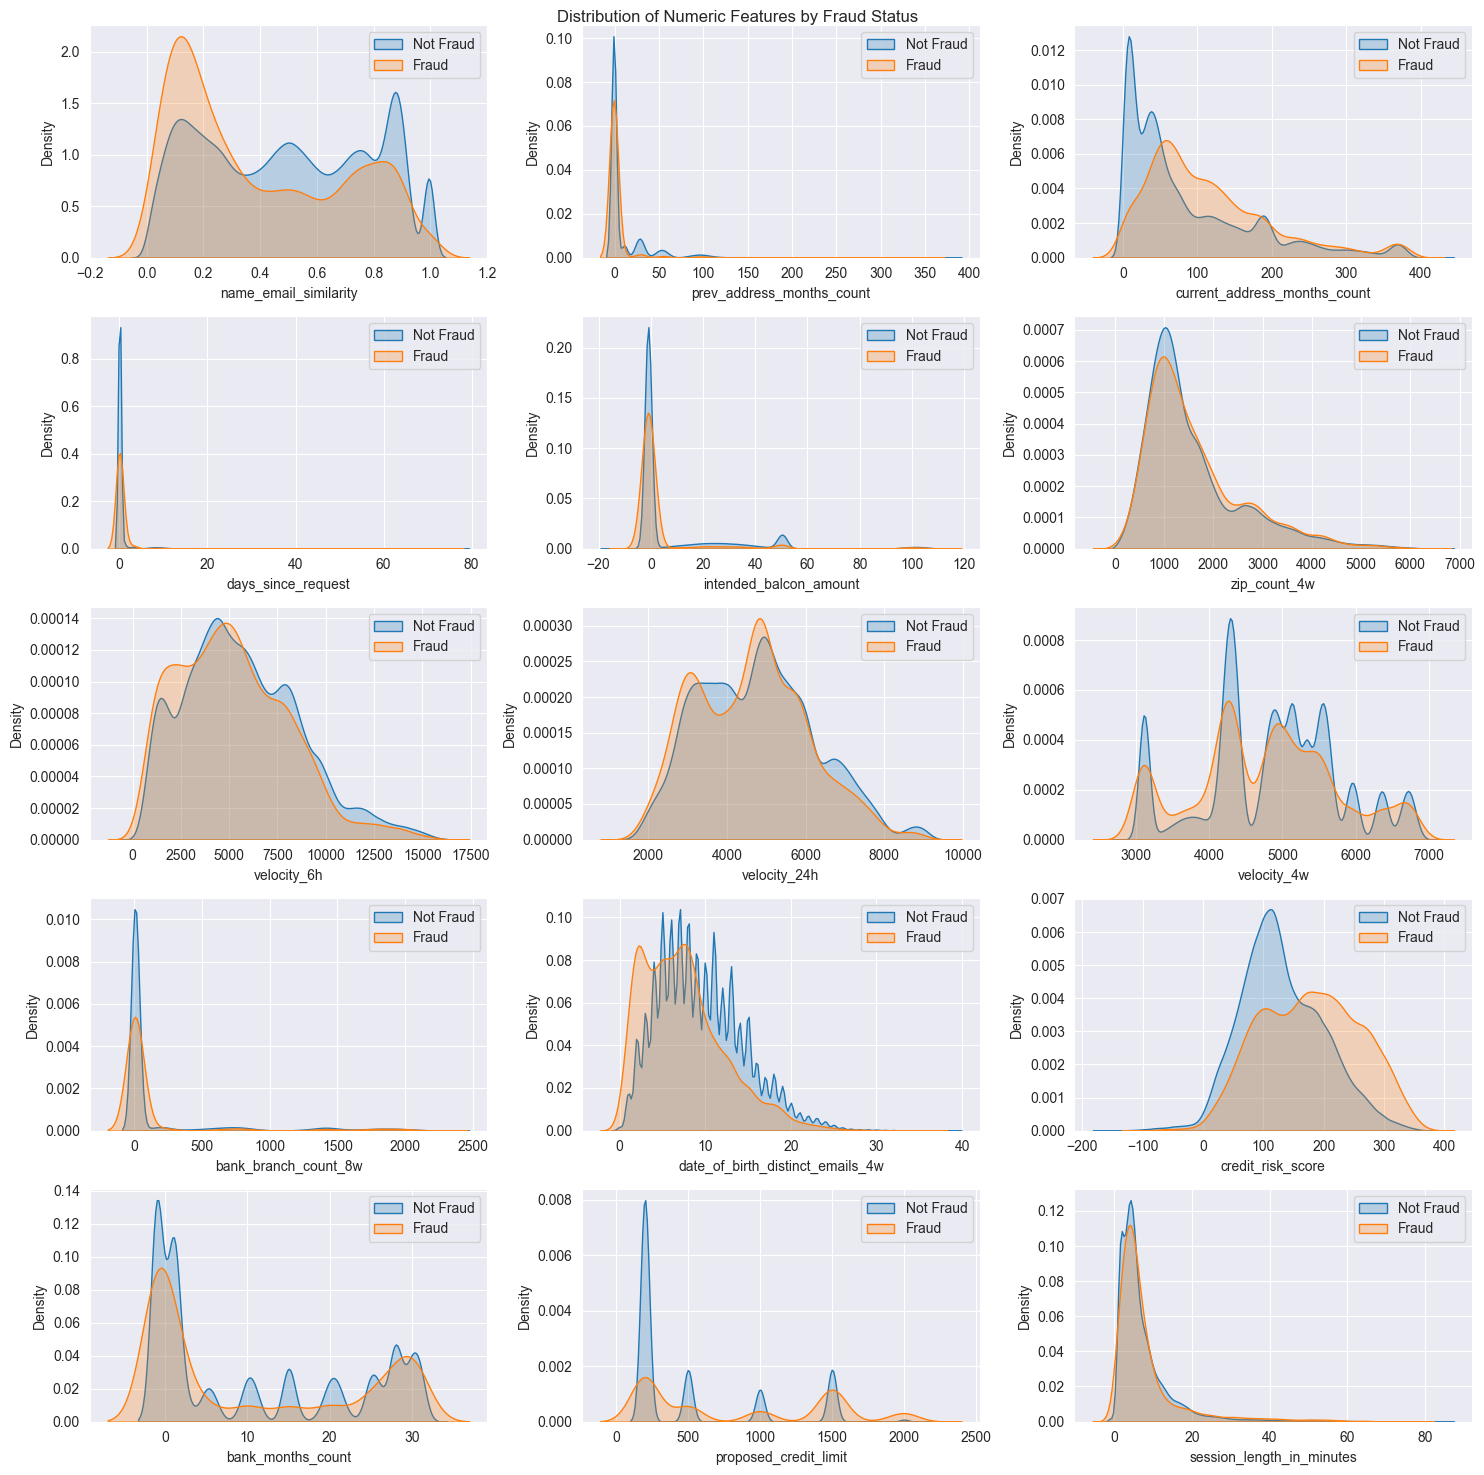

In [8]:
pandas_df = df.toPandas()
# Create a grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))

# Add a title to the figure
fig.suptitle('Distribution of Numeric Features by Fraud Status')

# Loop through the numeric features and plot a kernel density plot for each feature
for i, feature in enumerate(numeric_features):
    ax = axes[i // 3][i % 3]
    sns.kdeplot(data=pandas_df[pandas_df['fraud_bool'] == 0][feature], fill=True, ax=ax, label='Not Fraud')
    sns.kdeplot(data=pandas_df[pandas_df['fraud_bool'] == 1][feature], fill=True, ax=ax, label='Fraud')
    ax.set_xlabel(feature)
    ax.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

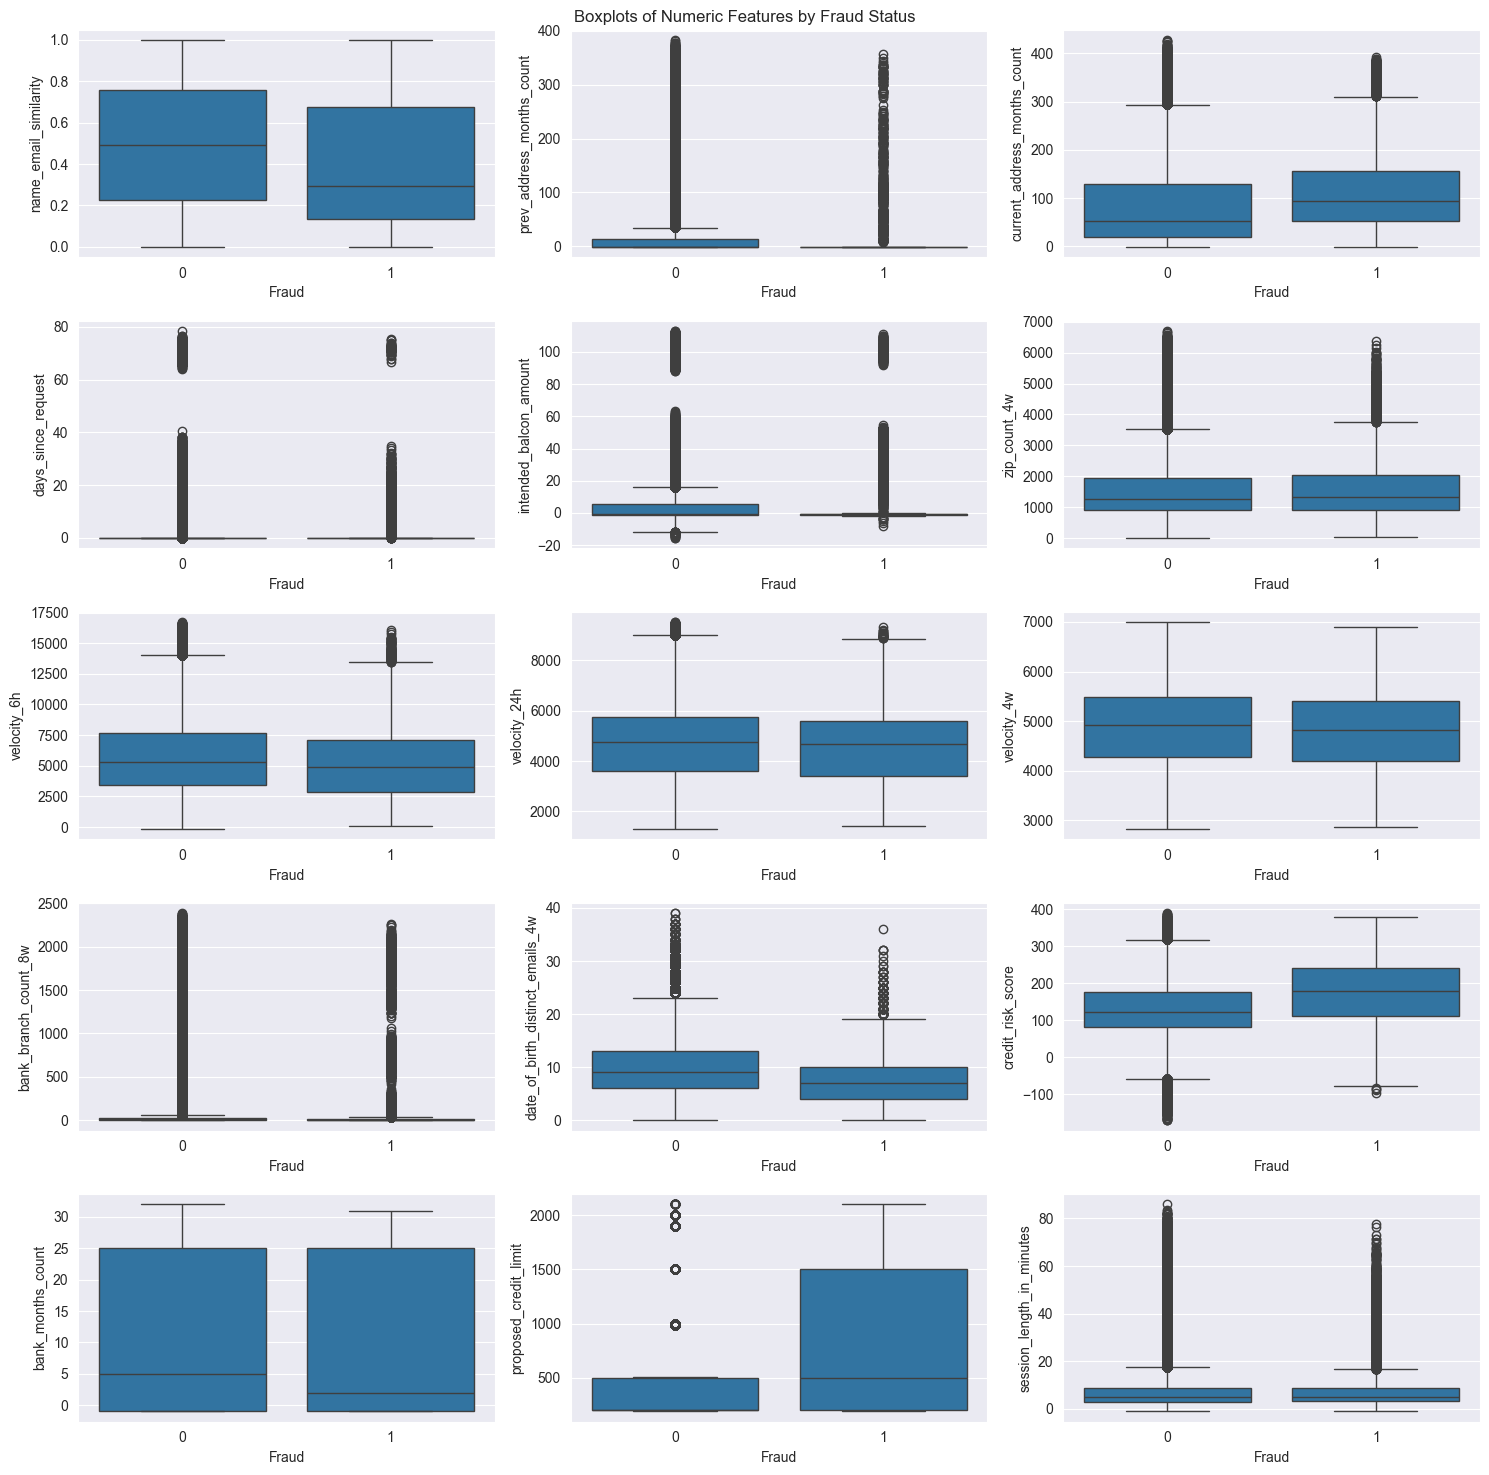

In [10]:
# Looking at outlier values
# Create a grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))

# Add a title to the figure
fig.suptitle('Boxplots of Numeric Features by Fraud Status')

# Loop through the numeric features and plot a boxplot for each feature
for i, feature in enumerate(numeric_features):
    ax = axes[i // 3][i % 3]
    sns.boxplot(data=pandas_df, x='fraud_bool', y=feature, ax=ax)
    ax.set_xlabel('Fraud')
    ax.set_ylabel(feature)
    
# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

## Checking for frauds in the dataset over time using the month column

In [11]:

# Convert the 'month' column to a string
df = df.withColumn('month', col('month').cast(StringType()))

# Group by month and fraud_bool, count occurrences, and calculate percentage
fraud_by_month = df.groupBy('month', 'fraud_bool').count()

fraud_by_month = fraud_by_month.withColumn('percentage', (col('count') / df.count()) * 100)

fraud_by_month = fraud_by_month.orderBy('month', 'fraud_bool')

fraud_by_month.show()

+-----+----------+------+------------------+
|month|fraud_bool| count|        percentage|
+-----+----------+------+------------------+
|    0|         0|130940|            13.094|
|    0|         1|  1500|              0.15|
|    1|         0|126422|           12.6422|
|    1|         1|  1198|            0.1198|
|    2|         0|135781|13.578100000000001|
|    2|         1|  1198|            0.1198|
|    3|         0|149544|14.954400000000001|
|    3|         1|  1392|            0.1392|
|    4|         0|126239|12.623899999999999|
|    4|         1|  1452|            0.1452|
|    5|         0|117912|           11.7912|
|    5|         1|  1411|            0.1411|
|    6|         0|106718|           10.6718|
|    6|         1|  1450|             0.145|
|    7|         0| 95415|            9.5415|
|    7|         1|  1428|            0.1428|
+-----+----------+------+------------------+


Frauds and non frauds are distributed uniformly over the months.

# Data Preparation Section

In [63]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

## Encoding categorical values

In [75]:
# Creating a list of the categorical features in the dataset
categorical_variables = [col for col in df.columns
                         if isinstance(df.schema[col].dataType, StringType)]

print(categorical_variables)

['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']


In [76]:
categorical_variables.remove('month')

print(categorical_variables)

ValueError: list.remove(x): x not in list

In [77]:
# Step 1: Create StringIndexers and OneHotEncoders for each column
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_variables]
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded") for col in categorical_variables]

# Step 2: Create a pipeline with both indexers and encoders
pipeline = Pipeline(stages=indexers + encoders)

# Step 3: Fit the pipeline and transform the DataFrame
df_encoded = pipeline.fit(df).transform(df)

# Step 4: Select only the new encoded columns, along with other columns if needed
encoded_column_names = [col + "_encoded" for col in categorical_variables]
other_columns = [col for col in df.columns if col not in categorical_variables]  # Get other original columns

df_final = df_encoded.select(*other_columns, *encoded_column_names)

# Show the transformed DataFrame
df_final.show()

+----------+------------------+---------------------+-------------------------+----------------------------+------------+------------------+----------------------+------------+------------------+------------------+------------------+--------------------+--------------------------------+-----------------+-------------+----------------+------------------+-----------------+---------------+---------------------+---------------+-------------------------+------------------+-------------------------+------------------+-----+--------------------+-------------------------+----------------------+--------------+-----------------+
|fraud_bool|            income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|days_since_request|intended_balcon_amount|zip_count_4w|       velocity_6h|      velocity_24h|       velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|credit_risk_score|email_is_free|phone_home_valid|phone_mobile_valid|bank_months_count|

## Min-Max Normalization of numerical features

In [78]:
#Explicitly filter columns that are IntegerType or DoubleType
numerical_features = [
    col for col in df_final.columns
    if isinstance(df_final.schema[col].dataType, (IntegerType, DoubleType))
]

print("Numerical Features:")
print(numerical_features)

Numerical Features:
['fraud_bool', 'income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'month']


In [79]:
#Apply MinMax norm
# Step 2: Assemble these numeric features into a single vector column
assembler = VectorAssembler(inputCols=numeric_features, outputCol="features_vector")

# Step 3: Apply MinMaxScaler to scale the vector to [0, 1] range
scaler = MinMaxScaler(inputCol="features_vector", outputCol="scaled_features_vector")

# Step 4: Apply the assembler and scaler in sequence
df_transformed = assembler.transform(df_final)
df_transformed = scaler.fit(df_transformed).transform(df_transformed)

# Step 5: Convert the scaled vector back into individual columns and overwrite the original columns
df_transformed = df_transformed.withColumn("scaled_features_array", vector_to_array(col("scaled_features_vector")))

# Step 6: Overwrite each original column with its scaled value
for i, feature_name in enumerate(numeric_features):
    df_transformed = df_transformed.withColumn(feature_name, col("scaled_features_array")[i])

# Step 7: Drop intermediate columns to retain only the original set of columns with normalized values
df_transformed = df_transformed.drop("features_vector", "scaled_features_vector", "scaled_features_array")

root
 |-- fraud_bool: integer (nullable = true)
 |-- income: double (nullable = true)
 |-- name_email_similarity: double (nullable = true)
 |-- prev_address_months_count: double (nullable = true)
 |-- current_address_months_count: double (nullable = true)
 |-- customer_age: integer (nullable = true)
 |-- days_since_request: double (nullable = true)
 |-- intended_balcon_amount: double (nullable = true)
 |-- zip_count_4w: double (nullable = true)
 |-- velocity_6h: double (nullable = true)
 |-- velocity_24h: double (nullable = true)
 |-- velocity_4w: double (nullable = true)
 |-- bank_branch_count_8w: double (nullable = true)
 |-- date_of_birth_distinct_emails_4w: double (nullable = true)
 |-- credit_risk_score: double (nullable = true)
 |-- email_is_free: integer (nullable = true)
 |-- phone_home_valid: integer (nullable = true)
 |-- phone_mobile_valid: integer (nullable = true)
 |-- bank_months_count: double (nullable = true)
 |-- has_other_cards: integer (nullable = true)
 |-- proposed

In [82]:
df_transformed.show()

+----------+------------------+---------------------+-------------------------+----------------------------+------------+--------------------+----------------------+-------------------+-------------------+-------------------+------------------+--------------------+--------------------------------+-------------------+-------------+----------------+------------------+-------------------+---------------+---------------------+---------------+-------------------------+------------------+-------------------------+------------------+-----+--------------------+-------------------------+----------------------+--------------+-----------------+
|fraud_bool|            income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|  days_since_request|intended_balcon_amount|       zip_count_4w|        velocity_6h|       velocity_24h|       velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|  credit_risk_score|email_is_free|phone_home_valid|phone_mob